<a href="https://colab.research.google.com/github/peremartra/fairness-pruning/blob/main/notebooks/04_Graphics_Base_Capabilities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fairness Pruning Research – Benchmark Visualizations
## 04 – Comparative Graphics for Base Model Results

### Visual Analytics of Baseline Performance (Unpruned Models)
by [Pere Martra](https://github.com/peremartra)

[![GitHub](https://img.shields.io/badge/⭐_Star-OptiPFair-orange?logo=github&logoColor=white)](https://github.com/peremartra/optipfair)
[![PyPI](https://img.shields.io/pypi/v/optipfair?logo=python&logoColor=white&label=v)](https://pypi.org/project/optipfair/)

**Repository:** [github.com/peremartra/fairness-pruning](https://github.com/peremartra/fairness-pruning)

---
**Recommended Colab Environment:** GPU (L4 / A100) for faster model loading – plotting itself does not require GPU.

**Models Visualized:**
* Llama-3.2-1B (base)
* Salamandra-2B (base)
* Llama-3.2-3B (base)

**Benchmark Groups:**
* Language Modeling: WikiText, Lambada-OpenAI
* English Reasoning & Knowledge: ARC-Challenge, HellaSwag, TruthfulQA, GSM8K, IFEval, MMLU
* Spanish / Cross-Lingual: ARC-ES, HellaSwag-ES, Belebele, MMLU-ES
* Deep Dives: MMLU (57 subcategories) and MMLU_ES (6 categories)
* Cross-Lingual Comparisons: EN − ES gaps (ARC, HellaSwag, MMLU)

**Primary Outputs:**
1. Grouped bar charts by task type
2. Perplexity comparison (WikiText / Lambada)
3. MMLU & MMLU_ES category bars
4. English vs Spanish performance gaps
5. Summary metrics (mean accuracy, mean perplexity, global MMLU)

**Objective:**
Provide a clear synthesized visual reference of baseline (unpruned) results to support: (a) comparison across model sizes, (b) task sensitivity analysis, and (c) pre-pruning bias diagnostics.

**Features:**
- ✅ Consistent style with evaluation notebooks
- ✅ Automatic download of result JSONs from GitHub
- ✅ Semantic benchmark grouping
- ✅ Exportable figures (PNG/PDF) with timestamp
- ✅ EN–ES gap table for cross-lingual diagnostics
- ✅ Easy extension (heatmaps / subcategory rankings)

**Suggested Future Extensions:**
- Heatmap of MMLU subcategories sorted by difficulty
- Efficiency curves (accuracy vs parameters)
- Variance visualization if repeated runs are added

> Note: All results here are from unpruned base models. Comparisons with pruned versions will appear in later notebooks.

---

In [1]:
# Install libraries if running in Colab (optional)
# !pip install -q seaborn matplotlib pandas

import json
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

# Style configuration
sns.set_theme(style="whitegrid")
PALETTE = {
    "Llama-3.2-1B": "#1f77b4",      # blue
    "Salamandra-2B": "#ff7f0e",     # orange
    "Llama-3.2-3B": "#2ca02c"       # green
}
MODEL_FILE_MAP = {
    "Llama-3.2-1B": "results/meta_llama_llama_3.2_1b.json",
    "Salamandra-2B": "results/bsc_lt_salamandra_2b.json",
    "Llama-3.2-3B": "results/meta_llama_llama_3.2_3b.json"
}
OUTPUT_DIR = Path("results/figures")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("✅ Imports complete")
print(f"📁 Figures output directory: {OUTPUT_DIR}")

✅ Imports complete
📁 Figures output directory: results/figures


In [2]:
# Download result JSONs from GitHub (ensures availability when running in Colab)
RESULTS_REMOTE_BASE = "https://raw.githubusercontent.com/peremartra/fairness-pruning/main/results"
LOCAL_RESULTS_DIR = Path("results")
LOCAL_RESULTS_DIR.mkdir(exist_ok=True)

remote_files = {
    "bsc_lt_salamandra_2b.json": f"{RESULTS_REMOTE_BASE}/bsc_lt_salamandra_2b.json",
    "meta_llama_llama_3.2_1b.json": f"{RESULTS_REMOTE_BASE}/meta_llama_llama_3.2_1b.json",
    "meta_llama_llama_3.2_3b.json": f"{RESULTS_REMOTE_BASE}/meta_llama_llama_3.2_3b.json",
}

import subprocess
for fname, url in remote_files.items():
    dest = LOCAL_RESULTS_DIR / fname
    if not dest.exists():
        try:
            subprocess.run(["wget", "-q", url, "-O", str(dest)], check=True)
            print(f"✅ Downloaded {fname}")
        except subprocess.CalledProcessError:
            print(f"❌ Failed to download {fname} from {url}")
    else:
        print(f"⚙️ Using existing local file: {fname}")

# Verify mapping still valid
for model, path in MODEL_FILE_MAP.items():
    if not Path(path).exists():
        print(f"⚠️ Expected file missing for {model}: {path}")
    else:
        print(f"📁 Ready: {path}")

✅ Downloaded bsc_lt_salamandra_2b.json
✅ Downloaded meta_llama_llama_3.2_1b.json
✅ Downloaded meta_llama_llama_3.2_3b.json
📁 Ready: results/meta_llama_llama_3.2_1b.json
📁 Ready: results/bsc_lt_salamandra_2b.json
📁 Ready: results/meta_llama_llama_3.2_3b.json


# 2. Data Loading & Preprocessing

Load JSON results produced by evaluation notebook and convert into structured DataFrames for visualization.

In [3]:
def safe_float(x):
    """Safely convert value to float; return None if not possible or 'N/A'."""
    if x in (None, "N/A"):
        return None
    try:
        return float(x)
    except (ValueError, TypeError):
        return None


def load_json(path: str) -> dict:
    with open(path, 'r') as f:
        return json.load(f)


def load_all_results(model_file_map=MODEL_FILE_MAP):
    data = {}
    for model_name, file_path in model_file_map.items():
        try:
            raw = load_json(file_path)
            data[model_name] = raw.get("results", {})
            print(f"✅ Loaded: {file_path}")
        except FileNotFoundError:
            print(f"❌ Missing file: {file_path}")
    return data

results_raw = load_all_results()

# Flatten simple tasks into a DataFrame (excluding deep MMLU variants for separate handling)
rows = []
for model_name, tasks in results_raw.items():
    for task_name, metrics in tasks.items():
        if task_name in ("mmlu", "global_mmlu_es"):
            continue  # handled separately
        row = {
            "model": model_name,
            "task": task_name,
            # Common accuracy metrics
            "accuracy": safe_float(metrics.get("accuracy")),
            "acc_norm": safe_float(metrics.get("acc_norm")),
            # Perplexity metrics
            "perplexity": safe_float(metrics.get("perplexity")),
            "word_perplexity": safe_float(metrics.get("word_perplexity")),
            "byte_perplexity": safe_float(metrics.get("byte_perplexity,none")),
        }
        # Add task-specific fields if present
        # GSM8K
        if task_name == "gsm8k":
            row["gsm8k_exact_match_strict"] = safe_float(metrics.get("exact_match,strict-match"))
            row["gsm8k_exact_match_flexible"] = safe_float(metrics.get("exact_match,flexible-extract"))
        # IFEval
        if task_name == "ifeval":
            row["ifeval_prompt_strict"] = safe_float(metrics.get("prompt_level_strict_acc,none"))
            row["ifeval_prompt_loose"] = safe_float(metrics.get("prompt_level_loose_acc,none"))
            row["ifeval_inst_strict"] = safe_float(metrics.get("inst_level_strict_acc,none"))
            row["ifeval_inst_loose"] = safe_float(metrics.get("inst_level_loose_acc,none"))
        rows.append(row)

base_df = pd.DataFrame(rows)
print(f"\n📊 Base metrics DataFrame shape: {base_df.shape}")
print(base_df.head().to_string())

# Prepare MMLU detailed DataFrame
mmlu_rows = []
for model_name, tasks in results_raw.items():
    if "mmlu" not in tasks:
        continue
    mmlu = tasks["mmlu"]
    subcats = mmlu.get("subcategories", {})
    # Overall + top-level categories
    mmlu_rows.append({
        "model": model_name,
        "type": "overall",
        "category": "overall",
        "score": safe_float(mmlu.get("accuracy"))
    })
    for cat_key in ["category_STEM", "category_Humanities", "category_Social_Sciences", "category_Other"]:
        mmlu_rows.append({
            "model": model_name,
            "type": "top_category",
            "category": cat_key.replace("category_", "").lower(),
            "score": safe_float(mmlu.get(cat_key))
        })
    # Subcategories
    for sub_name, value in subcats.items():
        mmlu_rows.append({
            "model": model_name,
            "type": "subcategory",
            "category": sub_name,
            "score": safe_float(value)
        })

mmlu_df = pd.DataFrame(mmlu_rows)
print(f"\n📊 MMLU DataFrame: {mmlu_df.shape} (including subcategories)")
print(mmlu_df.head().to_string())

# Prepare MMLU_ES detailed DataFrame
mmlu_es_rows = []
for model_name, tasks in results_raw.items():
    if "global_mmlu_es" not in tasks:
        continue
    mmlu_es = tasks["global_mmlu_es"]
    subcats = mmlu_es.get("subcategories", {})
    mmlu_es_rows.append({
        "model": model_name,
        "type": "overall",
        "category": "overall",
        "score": safe_float(mmlu_es.get("accuracy"))
    })
    # Spanish top categories live in subcategories directly
    for sub_name, value in subcats.items():
        mmlu_es_rows.append({
            "model": model_name,
            "type": "top_category",
            "category": sub_name,
            "score": safe_float(value)
        })

mmlu_es_df = pd.DataFrame(mmlu_es_rows)
print(f"\n📊 MMLU_ES DataFrame: {mmlu_es_df.shape}")
print(mmlu_es_df.head().to_string())

# Grouping definitions for plots
GROUPS = {
    "language_modeling": ["wikitext", "lambada_openai"],
    "english_reasoning": ["arc_challenge", "hellaswag", "truthfulqa_mc2"],
    "spanish_benchmarks": ["arc_es", "hellaswag_es", "belebele_spa_Latn"],
    "specialized": ["gsm8k", "ifeval"],
}

print("\n✅ Data loading & preprocessing complete")

✅ Loaded: results/meta_llama_llama_3.2_1b.json
✅ Loaded: results/bsc_lt_salamandra_2b.json
✅ Loaded: results/meta_llama_llama_3.2_3b.json

📊 Base metrics DataFrame shape: (36, 13)
          model            task  accuracy  acc_norm  perplexity  word_perplexity  byte_perplexity  ifeval_prompt_strict  ifeval_prompt_loose  ifeval_inst_strict  ifeval_inst_loose  gsm8k_exact_match_strict  gsm8k_exact_match_flexible
0  Llama-3.2-1B        wikitext       NaN       NaN         NaN              NaN           1.5912                   NaN                  NaN                 NaN                NaN                       NaN                         NaN
1  Llama-3.2-1B  lambada_openai       NaN       NaN        5.43              0.0              NaN                   NaN                  NaN                 NaN                NaN                       NaN                         NaN
2  Llama-3.2-1B          ifeval       NaN       NaN         NaN              NaN              NaN                0.099

# 3. Visualization Helpers

Utility functions to standardize figure generation (colors, saving, titles).

In [4]:
TIMESTAMP = datetime.now().strftime('%Y%m%d_%H%M%S')

def save_fig(name: str, fig):
    """Optionally save figure; kept for future export needs."""
    base = OUTPUT_DIR / f"{name}_{TIMESTAMP}"
    png_path = str(base) + ".png"
    pdf_path = str(base) + ".pdf"
    fig.savefig(png_path, bbox_inches='tight', dpi=150)
    fig.savefig(pdf_path, bbox_inches='tight')
    print(f"💾 Saved: {png_path} | {pdf_path}")


def plot_grouped_accuracy(group_key: str, save: bool = False):
    """Plot grouped accuracy metrics for a predefined task group and display inline."""
    tasks = GROUPS[group_key]
    subset = base_df[base_df['task'].isin(tasks)].copy()
    if subset.empty:
        print(f"⚠️ No data for group '{group_key}'")
        return
    fig, ax = plt.subplots(figsize=(10, 5))
    width = 0.2
    models = subset['model'].unique()
    x_positions = range(len(tasks))

    for i, model in enumerate(models):
        model_data = []
        for t in tasks:
            row = subset[(subset['model'] == model) & (subset['task'] == t)]
            if row.empty:
                model_data.append(None)
                continue
            if t == 'gsm8k':
                model_data.append(row.iloc[0]['gsm8k_exact_match_strict'])
            elif t == 'ifeval':
                model_data.append(row.iloc[0]['ifeval_prompt_strict'])
            else:
                model_data.append(row.iloc[0]['accuracy'])
        offsets = [x + (i - (len(models)-1)/2)*width for x in x_positions]
        ax.bar(offsets, model_data, width=width, label=model, color=PALETTE.get(model))

    ax.set_xticks(list(x_positions))
    ax.set_xticklabels(tasks, rotation=15)
    ax.set_ylabel('Accuracy / Score')
    ax.set_title(f"Grouped Performance: {group_key.replace('_', ' ').title()}")
    ax.legend(title='Model')
    ax.set_ylim(0, 1)
    sns.despine()
    if save:
        save_fig(f"group_{group_key}", fig)
    plt.show()


def plot_perplexities(save: bool = False):
    tasks = ['wikitext', 'lambada_openai']
    subset = base_df[base_df['task'].isin(tasks)]
    if subset.empty:
        print("⚠️ No perplexity data found")
        return
    fig, ax = plt.subplots(figsize=(8, 5))
    width = 0.25
    models = subset['model'].unique()
    x_positions = range(len(tasks))
    for i, model in enumerate(models):
        model_values = []
        for t in tasks:
            row = subset[(subset['model'] == model) & (subset['task'] == t)]
            if row.empty:
                model_values.append(None)
            else:
                val = row.iloc[0]['word_perplexity'] or row.iloc[0]['perplexity']
                model_values.append(val)
        offsets = [x + (i - (len(models)-1)/2)*width for x in x_positions]
        ax.bar(offsets, model_values, width=width, label=model, color=PALETTE.get(model))

    ax.set_xticks(list(x_positions))
    ax.set_xticklabels(tasks)
    ax.set_ylabel('Word Perplexity (lower is better)')
    ax.set_title('Language Modeling Performance')
    ax.legend(title='Model')
    sns.despine()
    if save:
        save_fig('language_modeling_perplexity', fig)
    plt.show()


def plot_mmlu_categories(save: bool = False):
    subset = mmlu_df[mmlu_df['type'] == 'top_category']
    if subset.empty:
        print("⚠️ No MMLU category data")
        return
    pivot = subset.pivot(index='category', columns='model', values='score')
    fig, ax = plt.subplots(figsize=(10, 5))
    pivot.plot(kind='bar', ax=ax, color=[PALETTE.get(m) for m in pivot.columns])
    ax.set_ylabel('Accuracy')
    ax.set_title('MMLU Category Performance')
    ax.set_ylim(0, 1)
    ax.legend(title='Model')
    sns.despine()
    if save:
        save_fig('mmlu_categories', fig)
    plt.show()


def plot_mmlu_es_categories(save: bool = False):
    subset = mmlu_es_df[mmlu_es_df['type'] == 'top_category']
    if subset.empty:
        print("⚠️ No MMLU_ES category data")
        return
    pivot = subset.pivot(index='category', columns='model', values='score')
    fig, ax = plt.subplots(figsize=(10, 5))
    pivot.plot(kind='bar', ax=ax, color=[PALETTE.get(m) for m in pivot.columns])
    ax.set_ylabel('Accuracy')
    ax.set_title('MMLU_ES Category Performance')
    ax.set_ylim(0, 1)
    ax.legend(title='Model')
    sns.despine()
    if save:
        save_fig('mmlu_es_categories', fig)
    plt.show()

print("✅ Visualization helpers (inline display) ready")

✅ Visualization helpers (inline display) ready


# 4. Generate Charts

Run grouped visualizations and deep dives. Additional fine-grained plots (e.g., subcategory heatmaps) can be added later.

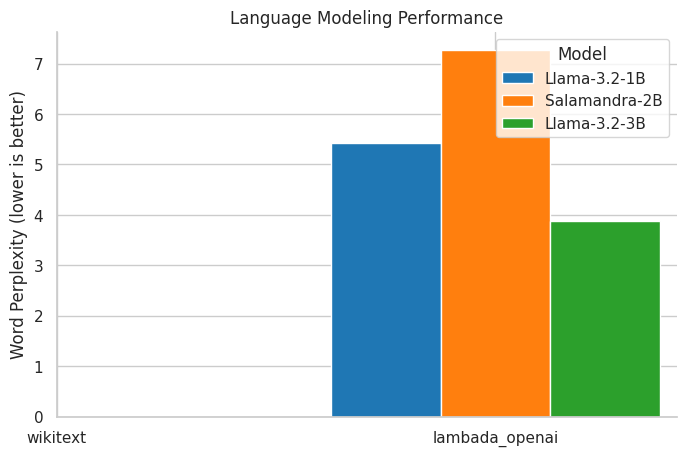

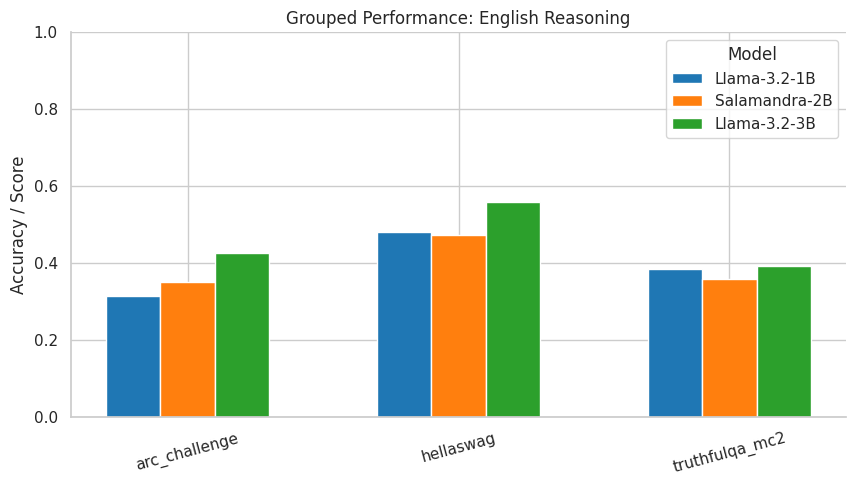

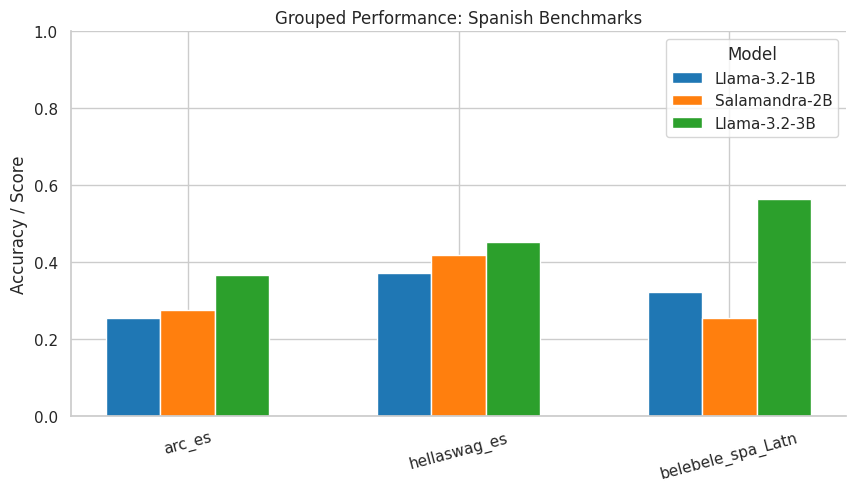

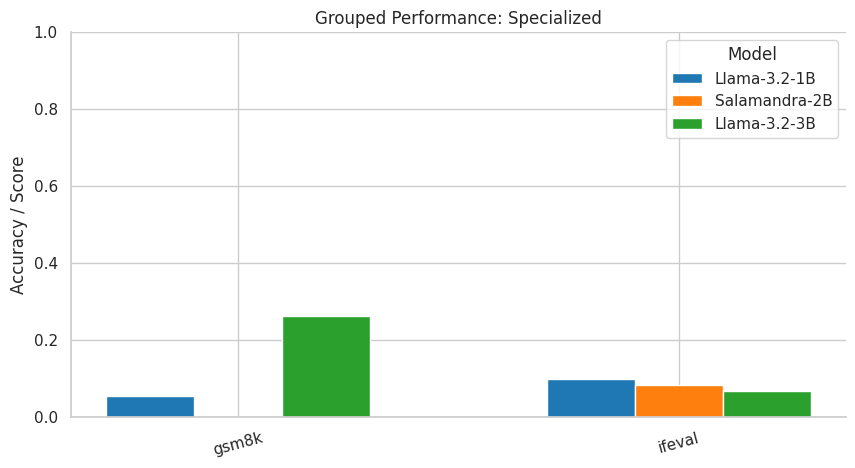

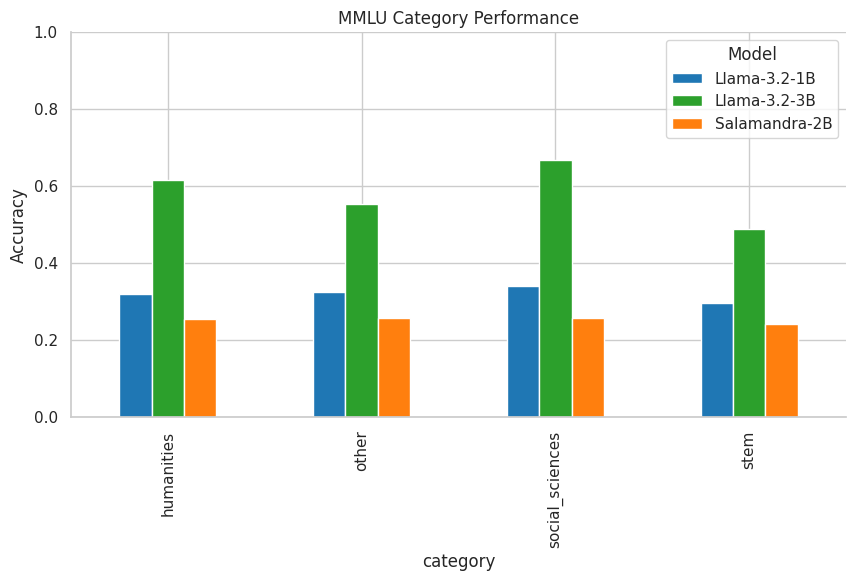

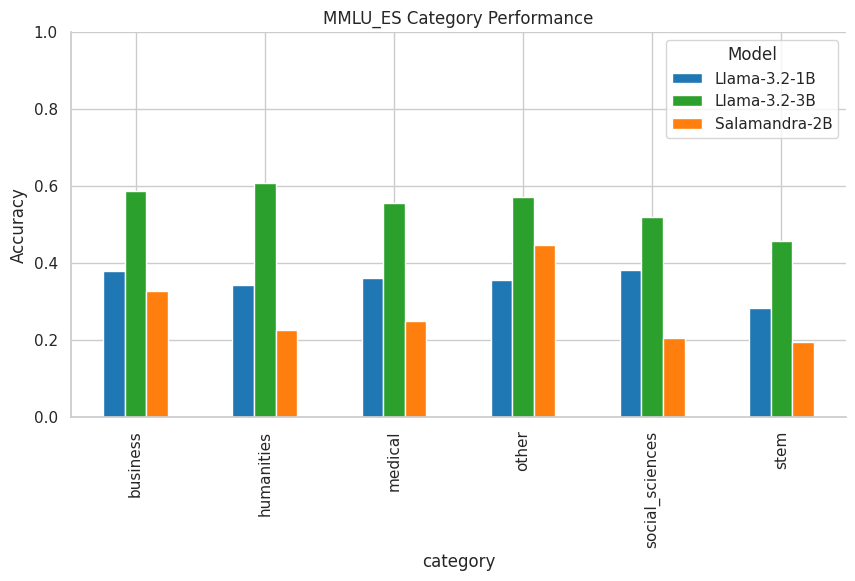

✅ All primary charts displayed inline


In [5]:
# Inline charts (set save=True if you also want files)
plot_perplexities()
plot_grouped_accuracy('english_reasoning')
plot_grouped_accuracy('spanish_benchmarks')
plot_grouped_accuracy('specialized')
plot_mmlu_categories()
plot_mmlu_es_categories()

print("✅ All primary charts displayed inline")

# 5. Cross-Lingual Comparison

Compute deltas between English and Spanish counterparts (ARC, HellaSwag, MMLU).

In [6]:
cross_rows = []
for model in MODEL_FILE_MAP.keys():
    # ARC
    arc_en = base_df[(base_df.model == model) & (base_df.task == 'arc_challenge')]['accuracy']
    arc_es = base_df[(base_df.model == model) & (base_df.task == 'arc_es')]['accuracy']
    # HellaSwag
    hs_en = base_df[(base_df.model == model) & (base_df.task == 'hellaswag')]['accuracy']
    hs_es = base_df[(base_df.model == model) & (base_df.task == 'hellaswag_es')]['accuracy']
    # MMLU overall
    mmlu_overall = mmlu_df[(mmlu_df.model == model) & (mmlu_df.type == 'overall')]['score']
    mmlu_es_overall = mmlu_es_df[(mmlu_es_df.model == model) & (mmlu_es_df.type == 'overall')]['score']

    cross_rows.append({
        'model': model,
        'arc_en': arc_en.iloc[0] if not arc_en.empty else None,
        'arc_es': arc_es.iloc[0] if not arc_es.empty else None,
        'hellaswag_en': hs_en.iloc[0] if not hs_en.empty else None,
        'hellaswag_es': hs_es.iloc[0] if not hs_es.empty else None,
        'mmlu_en': mmlu_overall.iloc[0] if not mmlu_overall.empty else None,
        'mmlu_es': mmlu_es_overall.iloc[0] if not mmlu_es_overall.empty else None,
    })

cross_df = pd.DataFrame(cross_rows)
print("Cross-lingual comparison table:")
print(cross_df.to_string(index=False))

# Plot deltas
fig, ax = plt.subplots(figsize=(10,5))
index = range(len(cross_df))
bar_width = 0.25
ax.bar([i - bar_width for i in index], cross_df['arc_en'] - cross_df['arc_es'], width=bar_width, label='ARC Δ (EN-ES)')
ax.bar(index, cross_df['hellaswag_en'] - cross_df['hellaswag_es'], width=bar_width, label='HellaSwag Δ (EN-ES)')
ax.bar([i + bar_width for i in index], cross_df['mmlu_en'] - cross_df['mmlu_es'], width=bar_width, label='MMLU Δ (EN-ES)')
ax.set_xticks(list(index))
ax.set_xticklabels(cross_df['model'], rotation=15)
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel('Accuracy Gap (English - Spanish)')
ax.set_title('Cross-Lingual Performance Gaps')
ax.legend()
sns.despine()
save_fig('cross_lingual_gaps', fig)
plt.close(fig)
print("✅ Cross-lingual comparison chart saved")

Cross-lingual comparison table:
        model  arc_en  arc_es  hellaswag_en  hellaswag_es  mmlu_en  mmlu_es
 Llama-3.2-1B  0.3148  0.2564        0.4810        0.3731   0.3198   0.3509
Salamandra-2B  0.3498  0.2769        0.4715        0.4203   0.2512   0.2752
 Llama-3.2-3B  0.4249  0.3675        0.5581        0.4532   0.5783   0.5495
💾 Saved: results/figures/cross_lingual_gaps_20251228_150907.png | results/figures/cross_lingual_gaps_20251228_150907.pdf
✅ Cross-lingual comparison chart saved


# 6. Summary & Export

Compile summary statistics and list generated figures.

In [7]:
summary_rows = []
for model in MODEL_FILE_MAP.keys():
    model_subset = base_df[base_df.model == model]
    avg_acc = model_subset['accuracy'].dropna().mean()
    avg_ppl = model_subset['word_perplexity'].dropna().mean()
    mmlu_score = mmlu_df[(mmlu_df.model == model) & (mmlu_df.type == 'overall')]['score']
    mmlu_es_score = mmlu_es_df[(mmlu_es_df.model == model) & (mmlu_es_df.type == 'overall')]['score']
    summary_rows.append({
        'model': model,
        'avg_accuracy': avg_acc,
        'avg_word_perplexity': avg_ppl,
        'mmlu_overall': mmlu_score.iloc[0] if not mmlu_score.empty else None,
        'mmlu_es_overall': mmlu_es_score.iloc[0] if not mmlu_es_score.empty else None,
    })
summary_df = pd.DataFrame(summary_rows)
print("Summary metrics:")
print(summary_df.to_string(index=False, float_format="%.4f"))

# Export summary CSV
summary_path = OUTPUT_DIR / f"summary_metrics_{TIMESTAMP}.csv"
summary_df.to_csv(summary_path, index=False)
print(f"\n💾 Summary CSV saved: {summary_path}")

# List generated figures
print("\n📁 Generated Figures:")
for f in sorted(OUTPUT_DIR.glob(f"*{TIMESTAMP}.*")):
    if f.suffix.lower() in ('.png', '.pdf'):
        print(f"  - {f.name}")

print("\n✅ Visualization process complete")

Summary metrics:
        model  avg_accuracy  avg_word_perplexity  mmlu_overall  mmlu_es_overall
 Llama-3.2-1B        0.3262               0.0000        0.3198           0.3509
Salamandra-2B        0.3189               0.0000        0.2512           0.2752
 Llama-3.2-3B        0.4022               0.0000        0.5783           0.5495

💾 Summary CSV saved: results/figures/summary_metrics_20251228_150907.csv

📁 Generated Figures:
  - cross_lingual_gaps_20251228_150907.pdf
  - cross_lingual_gaps_20251228_150907.png

✅ Visualization process complete


# 7. MMLU & MMLU_ES Heatmaps

Detailed performance visualization by subcategory:
- MMLU (57 subcategories): Sorted by average accuracy across models.
- MMLU_ES (6 categories): Direct comparative view.

Heatmaps include annotated values (0–1 range) to ease inspection of relative differences.

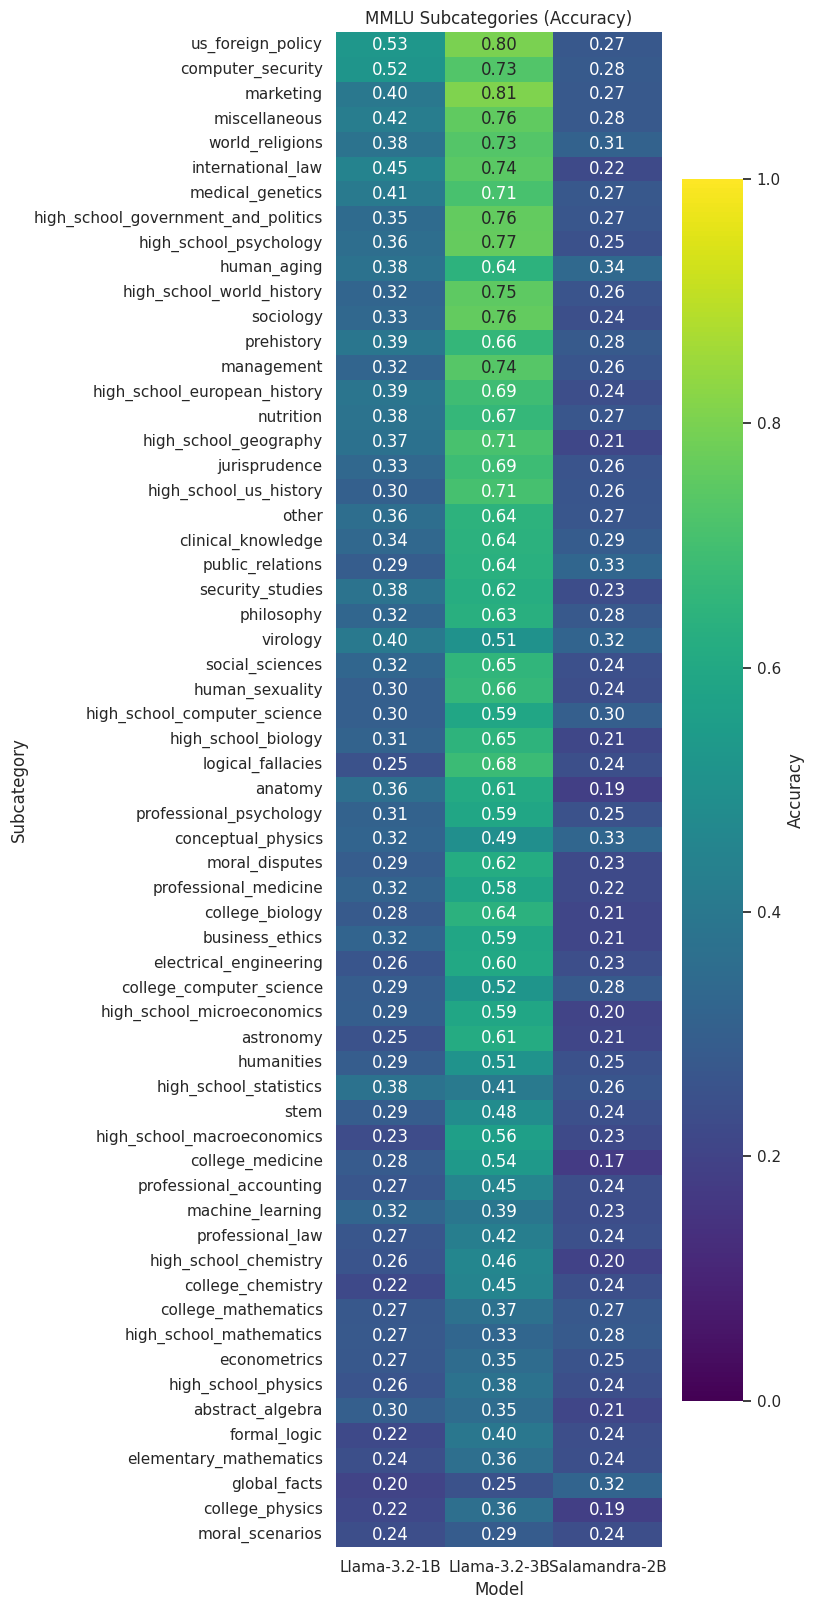

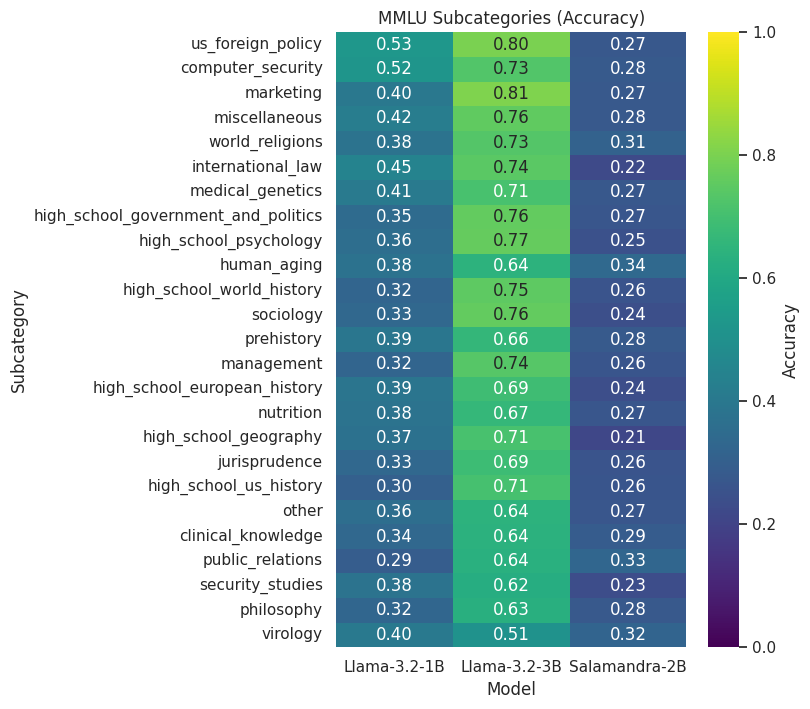

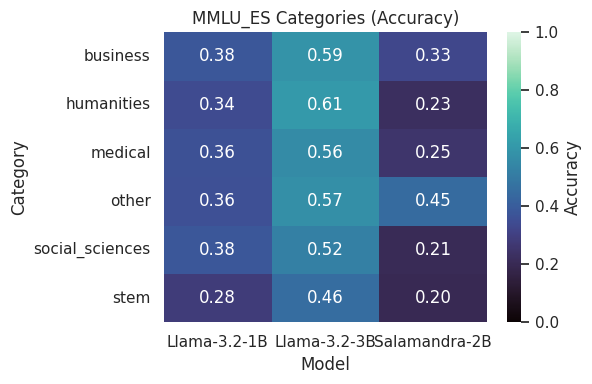

✅ Inline heatmaps displayed


In [8]:
def plot_mmlu_subcategory_heatmap(top_n=None, save: bool = False):
    """Generate an inline heatmap for MMLU subcategories.
    Args:
        top_n: if provided, limit to top_n subcategories by mean accuracy.
        save: whether to also save the figure to disk.
    """
    sub_df = mmlu_df[mmlu_df['type'] == 'subcategory'].copy()
    if sub_df.empty:
        print("⚠️ No MMLU subcategories available")
        return
    mean_scores = sub_df.groupby('category')['score'].mean().sort_values(ascending=False)
    ordered_categories = mean_scores.index.tolist()
    if top_n is not None:
        ordered_categories = ordered_categories[:top_n]
    pivot = sub_df[sub_df['category'].isin(ordered_categories)].pivot(index='category', columns='model', values='score')
    pivot = pivot.loc[ordered_categories]
    fig_height = max(4, len(pivot) * 0.25 + 1)
    fig, ax = plt.subplots(figsize=(8, fig_height))
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='viridis', vmin=0, vmax=1, cbar_kws={'label': 'Accuracy'}, ax=ax)
    ax.set_title('MMLU Subcategories (Accuracy)')
    ax.set_ylabel('Subcategory')
    ax.set_xlabel('Model')
    plt.tight_layout()
    if save:
        save_fig(f'mmlu_subcategories_heatmap_{"top"+str(top_n) if top_n else "all"}', fig)
    plt.show()


def plot_mmlu_es_heatmap(save: bool = False):
    sub_df = mmlu_es_df[mmlu_es_df['type'] == 'top_category'].copy()
    if sub_df.empty:
        print("⚠️ No MMLU_ES categories available")
        return
    pivot = sub_df.pivot(index='category', columns='model', values='score')
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='mako', vmin=0, vmax=1, cbar_kws={'label': 'Accuracy'}, ax=ax)
    ax.set_title('MMLU_ES Categories (Accuracy)')
    ax.set_ylabel('Category')
    ax.set_xlabel('Model')
    plt.tight_layout()
    if save:
        save_fig('mmlu_es_categories_heatmap', fig)
    plt.show()

# Inline execution (no saving by default)
plot_mmlu_subcategory_heatmap()
plot_mmlu_subcategory_heatmap(top_n=25)
plot_mmlu_es_heatmap()

print("✅ Inline heatmaps displayed")